# Pattern Compare

Aims to answer the question **Are there any key similarities or differences between malicious and benign samples in terms of API Call Patterns?** in **4.2.6. Dataset Analysis** of the study.

Note that this notebook only makes use of the verified xxxx_SampleHash_Common.csv file which represents a significant majority of the entire Oliveira dataset.  

## Import Libraries/Datasets

In [8]:
import pandas as pd
# from difflib import SequenceMatcher
import Levenshtein
import matplotlib.pyplot as plt
import time

malicious_df = pd.read_csv('./Manual_DBSCAN_Clustering_w_FalseLabels.csv', low_memory=False) #This should point to a verified <DataClustering>_SampleHash_Common.csv file
benign_df = pd.read_csv('./API_Patterns_Benign.csv') #This should point to the API_Patterns.csv file

#DROP ROWS WITH NA
import numpy as nan
malicious_df.dropna(inplace=True, subset=['type'])
malicious_df['type'].unique()

#Load list of API calls
API_LIST = "../api_calls.txt"
DELIMITER = "NaN"
API_FILE = open(API_LIST,"r")
APIS = API_FILE.readline().split
# APIS.append(DELIMITER) #serves as a label for NaN values for Instance-based datasets
API_FILE.close()

## DataFrame Preview

In [9]:
malicious_df.replace(to_replace='-',value='_', inplace=True)
malicious_df

,hash,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_94,t_95,t_96,t_97,t_98,t_99,malware,type,pattern,cluster
0,071e8c3f8922e186e57548cd4c703a5d,112,274,158,215,274,158,215,298,76,...,171,215,35,208,56,71,1,trojan,"RegOpenKeyExA,NtOpenKey,NtQueryValueKey,NtClos...",0
1,33f8e6d08a6aae939f25a8e0d63dd523,82,208,187,208,172,117,172,117,172,...,71,297,135,171,215,35,1,pua,"GetSystemTimeAsFileTime,NtAllocateVirtualMemor...",1
2,b68abd064e975e1c6d5f25e748663076,16,110,240,117,240,117,240,117,240,...,65,112,123,65,113,112,1,trojan,"SetUnhandledExceptionFilter,OleInitialize,LdrL...",2
3,72049be7bd30ea61297ea624ae198067,82,208,187,208,172,117,172,117,172,...,302,187,208,302,228,302,1,trojan,"GetSystemTimeAsFileTime,NtAllocateVirtualMemor...",3
4,c9b3700a77facf29172f32df6bc77f48,82,240,117,240,117,240,117,240,117,...,209,260,141,260,141,260,1,trojan,"GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProce...",4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42792,e3d6d58faa040f0f9742c9d0eaf58be4,82,240,117,240,117,240,117,240,117,...,260,141,260,141,260,141,1,trojan,"GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProce...",19
42793,9b917bab7f32188ae40c744f2be9aaf8,82,240,117,240,117,240,117,240,117,...,159,224,82,159,224,82,1,trojan,"GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProce...",12595
42794,35a18ee05f75f04912018d9f462cb990,82,240,117,240,117,240,117,240,117,...,141,260,141,260,141,260,1,trojan,"GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProce...",12596
42795,654139d715abcf7ecdddbef5a84f224b,82,240,117,240,117,240,117,240,117,...,260,141,260,141,260,141,1,trojan,"GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProce...",19


In [10]:
#Drop row that is falsely labelled.
#malicious_df.drop(malicious_df[(malicious_df['type']=='_')].index, inplace=True)
malicious_df

,hash,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_94,t_95,t_96,t_97,t_98,t_99,malware,type,pattern,cluster
0,071e8c3f8922e186e57548cd4c703a5d,112,274,158,215,274,158,215,298,76,...,171,215,35,208,56,71,1,trojan,"RegOpenKeyExA,NtOpenKey,NtQueryValueKey,NtClos...",0
1,33f8e6d08a6aae939f25a8e0d63dd523,82,208,187,208,172,117,172,117,172,...,71,297,135,171,215,35,1,pua,"GetSystemTimeAsFileTime,NtAllocateVirtualMemor...",1
2,b68abd064e975e1c6d5f25e748663076,16,110,240,117,240,117,240,117,240,...,65,112,123,65,113,112,1,trojan,"SetUnhandledExceptionFilter,OleInitialize,LdrL...",2
3,72049be7bd30ea61297ea624ae198067,82,208,187,208,172,117,172,117,172,...,302,187,208,302,228,302,1,trojan,"GetSystemTimeAsFileTime,NtAllocateVirtualMemor...",3
4,c9b3700a77facf29172f32df6bc77f48,82,240,117,240,117,240,117,240,117,...,209,260,141,260,141,260,1,trojan,"GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProce...",4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42792,e3d6d58faa040f0f9742c9d0eaf58be4,82,240,117,240,117,240,117,240,117,...,260,141,260,141,260,141,1,trojan,"GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProce...",19
42793,9b917bab7f32188ae40c744f2be9aaf8,82,240,117,240,117,240,117,240,117,...,159,224,82,159,224,82,1,trojan,"GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProce...",12595
42794,35a18ee05f75f04912018d9f462cb990,82,240,117,240,117,240,117,240,117,...,141,260,141,260,141,260,1,trojan,"GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProce...",12596
42795,654139d715abcf7ecdddbef5a84f224b,82,240,117,240,117,240,117,240,117,...,260,141,260,141,260,141,1,trojan,"GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProce...",19


In [11]:
benign_df

,hash,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,pattern
0,5b51d65972a349f90a86984c26b12b30,SetErrorMode,OleInitialize,LdrGetDllHandle,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,NtClose,NtQueryDirectoryFile,NtClose,LdrGetProcedureAddress,CoCreateInstance,NtOpenSection,CreateDirectoryW,NtCreateFile,LdrGetProcedureAddress,"SetErrorMode,OleInitialize,LdrGetDllHandle,Ldr..."
1,ceb8cc125478fad641daa4e04e9b2f19,GetSystemInfo,NtAllocateVirtualMemory,NtOpenSection,GetTempPathW,CreateDirectoryW,GetFileAttributesW,FindFirstFileExW,DeleteFileW,NtQueryDirectoryFile,...,NtClose,NtCreateMutant,NtClose,LdrGetDllHandle,LdrGetProcedureAddress,NtClose,NtCreateMutant,NtClose,NtCreateFile,"GetSystemInfo,NtAllocateVirtualMemory,NtOpenSe..."
2,f108600edf46d7c20f6acc522aeba6df,GetSystemTimeAsFileTime,NtProtectVirtualMemory,SetUnhandledExceptionFilter,GetTimeZoneInformation,GetSystemTimeAsFileTime,GetTimeZoneInformation,GetSystemTimeAsFileTime,GetTimeZoneInformation,GetSystemTimeAsFileTime,...,SetErrorMode,GetFileAttributesExW,SetErrorMode,NtAllocateVirtualMemory,SetErrorMode,GetFileAttributesExW,SetErrorMode,FindFirstFileExW,NtQueryDirectoryFile,"GetSystemTimeAsFileTime,NtProtectVirtualMemory..."
3,711be6337cb78a948f04759a0bd210ce,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,LdrGetProcedureAddress,NtAllocateVirtualMemory,LdrGetProcedureAddress,GetSystemMetrics,LdrLoadDll,LdrGetProcedureAddress,GetSystemMetrics,NtAllocateVirtualMemory,LdrLoadDll,"GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProce..."
4,6de26f67ceb1e3303b889489010f4c3f,SetErrorMode,OleInitialize,LdrGetDllHandle,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,NtClose,NtQueryDirectoryFile,NtClose,LdrGetProcedureAddress,GetSystemWindowsDirectoryW,LoadStringW,GetSystemWindowsDirectoryW,GetSystemDirectoryW,RegOpenKeyExW,"SetErrorMode,OleInitialize,LdrGetDllHandle,Ldr..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1074,d282ef96a93986f89825508812958354,SetErrorMode,OleInitialize,LdrGetDllHandle,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,NtClose,LdrGetProcedureAddress,NtAllocateVirtualMemory,LdrGetDllHandle,LdrGetProcedureAddress,LdrGetDllHandle,LdrGetProcedureAddress,LdrGetDllHandle,LdrGetProcedureAddress,"SetErrorMode,OleInitialize,LdrGetDllHandle,Ldr..."
1075,c0389d256f976044adf570f0df908953,GetSystemTimeAsFileTime,SetUnhandledExceptionFilter,GetCursorPos,SetErrorMode,FindResourceW,SetWindowsHookExW,CoInitializeEx,NtDuplicateObject,NtAllocateVirtualMemory,...,NtAllocateVirtualMemory,LdrLoadDll,LdrGetProcedureAddress,NtAllocateVirtualMemory,GetSystemMetrics,RegOpenKeyExW,NtAllocateVirtualMemory,GetSystemMetrics,NtAllocateVirtualMemory,"GetSystemTimeAsFileTime,SetUnhandledExceptionF..."
1076,20316e717de5db169aecbb67377504ce,SetUnhandledExceptionFilter,NtCreateMutant,NtAllocateVirtualMemory,NtClose,NtCreateMutant,NtClose,NtCreateMutant,NtClose,NtAllocateVirtualMemory,...,RegOpenKeyExW,RegQueryValueExW,RegCloseKey,RegOpenKeyExW,RegQueryValueExW,RegCloseKey,RegOpenKeyExW,RegQueryValueExW,RegCloseKey,"SetUnhandledExceptionFilter,NtCreateMutant,NtA..."
1077,ce945d424b93ea73fbbedf0254f6bc07,NtClose,NtOpenKey,NtQueryValueKey,NtClose,NtOpenKey,NtQueryValueKey,NtClose,LdrGetDllHandle,LdrGetProcedureAddress,...,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrGetDllHandle,FindResourceExW,LoadResource,"NtClose,NtOpenKey,NtQueryValueKey,NtClose,NtOp..."


## Identify Malware Types

Same as the output of `1 MalwareTypes_in_Dataset.txt`

In [12]:
'''Identify popular malware types in the dataset per Type as validated by VirusTotal.'''

def identify(malware_type:str):
    '''Identify and count the malware types per type'''
    print(f"{malware_type.upper()} LABEL")
    unique = list(malicious_df[malware_type].unique())
    if '_' in unique:
        unique.remove('_')
    quantities = []
    for t in unique:
        quantities.append([t, len(malicious_df[malicious_df[malware_type]==t])])
    quantities.sort(key=lambda ls: ls[1], reverse=True)
    for q in quantities:
        print(f"{q[0]:12s}: {q[1]}")
    print("")
    
'''Executes the identification for each type'''
types = ['type']
for i in types:    
    identify(i)

TYPE LABEL
trojan      : 33352
downloader  : 2249
pua         : 2135
adware      : 1815
ransomware  : 341
miner       : 125
virus       : 79
spyware     : 48
hacktool    : 7
dropper     : 5
worm        : 3



## Extract API Patterns

In [13]:
malicious_patterns = malicious_df['pattern'].to_list()
print("Malicious Sample API Patterns: ", len(malicious_patterns))
#display(malicious_patterns)

benign_patterns = benign_df['pattern'].to_list()
print("Benign Sample API Patterns: ", len(benign_patterns))
#display(benign_patterns)

Malicious Sample API Patterns:  42797
Benign Sample API Patterns:  1079


## Compare API Call Patterns

**Note that this uses the full API Call Patterns (i.e., Time-based Behaviors)**

Find those most similar unique malicious API call patterns that match those unique benign API call patterns.

In [14]:
#This code block may take a while to complete. SequenceMatcher.ratio() is deemed slow even by its documentation.
print("Comparing API Call Patterns...")
ratio = 0
ratios = []
start = time.time()

unique_malicious = list(malicious_df['pattern'].unique())
unique_benign = list(benign_df['pattern'].unique())
print(f"No. of unique malicious patterns: {len(unique_malicious)}")
print(f"No. of unique benign patterns: {len(unique_benign)}")
print("")
for m,ma in enumerate(unique_malicious): #For efficiency's sake, let's just compare it to unique malicious samples. Hashes that match the same malicious pattern will be collected in batches instead of one by one.
    mal_df = malicious_df[malicious_df['pattern']== ma]
    st = time.time()
    #if ma in unique_benign: # Only compute those that unique malicious patterns that are also in unique benign (shortens overall computation time)
    for b, be in enumerate(unique_benign): #For efficiency's sake, let's just compare it to unique benign samples. Hashes that match the same benign pattern will be collected in batches instead of one by one.
        ratios.append({'ratio': Levenshtein.seqratio(ma.split(',') , be.split(',')), #<=== SequenceMatcher.ratio() is too slow given the number of patterns to compare.
                    'benign_pattern':be, 'malicious_pattern': ma,
                    'type':mal_df['type'].to_list(), 
                    'malicious_hash':mal_df['hash'].to_list(), 
                    'benign_hash':benign_df[benign_df['pattern'] == be]['hash'].to_list()})
    print(f"Unique Mal. Pattern {m} {ma[0:30]}... @ {time.time()-st:.4f}s")
elapsed = time.time()-start

Comparing API Call Patterns...
No. of unique malicious patterns: 12597
No. of unique benign patterns: 624

Unique Mal. Pattern 0 RegOpenKeyExA,NtOpenKey,NtQuer... @ 1.4611s
Unique Mal. Pattern 1 GetSystemTimeAsFileTime,NtAllo... @ 1.0227s
Unique Mal. Pattern 2 SetUnhandledExceptionFilter,Ol... @ 0.9925s
Unique Mal. Pattern 3 GetSystemTimeAsFileTime,NtAllo... @ 0.9089s
Unique Mal. Pattern 4 GetSystemTimeAsFileTime,LdrLoa... @ 0.9923s
Unique Mal. Pattern 5 LdrGetProcedureAddress,NtAlloc... @ 1.0999s
Unique Mal. Pattern 6 NtClose,NtOpenKey,NtQueryValue... @ 1.1812s
Unique Mal. Pattern 7 GetSystemTimeAsFileTime,LdrLoa... @ 0.9209s
Unique Mal. Pattern 8 GetSystemTimeAsFileTime,LdrLoa... @ 0.9783s
Unique Mal. Pattern 9 GetSystemTimeAsFileTime,NtAllo... @ 1.0988s
Unique Mal. Pattern 10 LdrGetDllHandle,LdrGetProcedur... @ 1.3093s
Unique Mal. Pattern 11 GetSystemTimeAsFileTime,LdrLoa... @ 1.7178s
Unique Mal. Pattern 12 GetSystemTimeAsFileTime,LdrGet... @ 1.0919s
Unique Mal. Pattern 13 GetSystem

KeyboardInterrupt: 

In [ ]:
str_output = ""
size = len(benign_patterns) * len(malicious_patterns)
for r in ratios:
    ratio += r['ratio']
ratio /= size
ratios.sort(reverse=True,key=lambda ratio: ratio['ratio'])
str_output += f"Average Similarity Ratio: {ratio*100:.4f}%\n"
str_output += f"Time Elapsed: {elapsed:0.4f}s\n"
str_output += f"Time per Sample: {elapsed/size:0.4f}s\n"

with open("./Output/3 Similarity Ratio.txt", 'w') as f:
    f.write(str_output)
    f.flush()
    f.close()

### Distribution of Similarity Ratios

The graph that the code block below produces indicates the most common similarity ratio between malicious and benign samples in terms of unique API calls.

Being bias on the left means that most malicious API Call Patterns are different to that found in benign API Call Patterns (but that does not mean that there are no same ones that exist).

Being bias on the right means that most malicious API Call Patterns are the same to that found in benign API Call Patterns (but that does not mean that there are no different ones that exist).

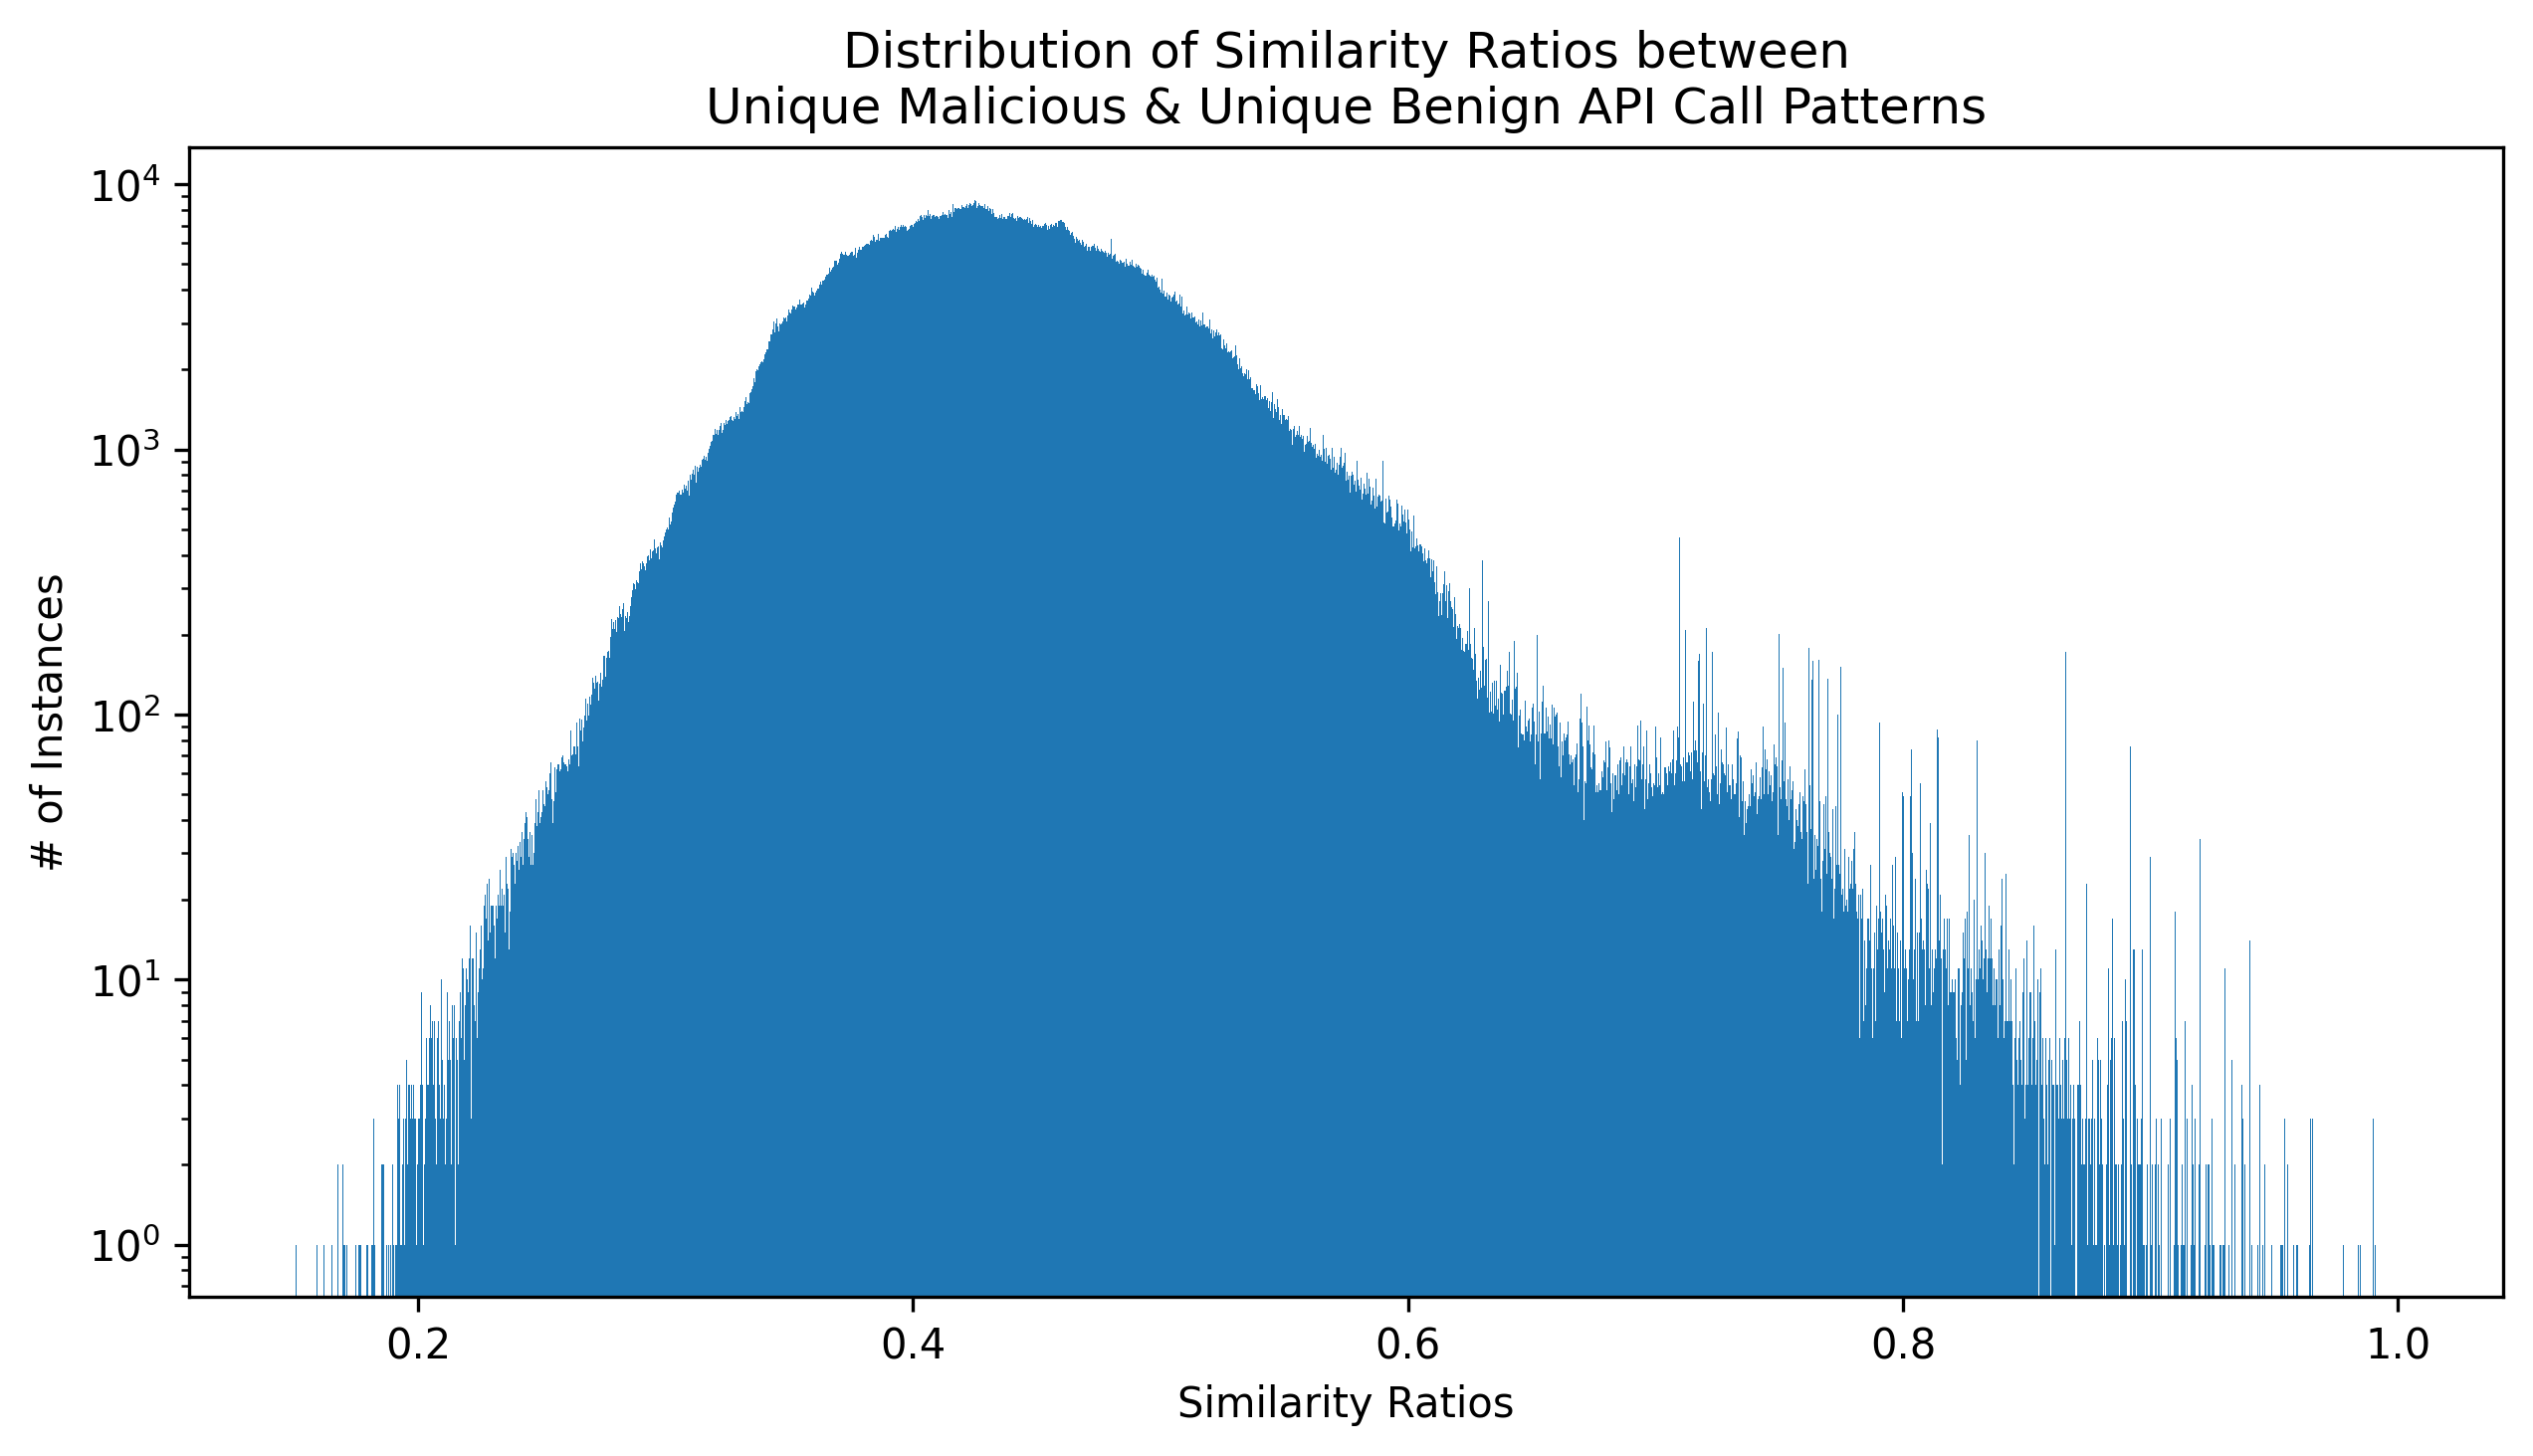

In [ ]:
ratio_only = []
for r in ratios:
    ratio_only.append(r['ratio'])
plt.figure(figsize=(10,5), dpi=300)
plt.title('Distribution of Similarity Ratios between\nUnique Malicious & Unique Benign API Call Patterns')
plt.xlabel('Similarity Ratios')
plt.ylabel('# of Instances')
n, bins, patches = plt.hist(ratio_only, bins=5000, orientation='vertical', log=True)
plt.savefig("./Output/3 Distribution_Similarity_Ratio_Log.png")
plt.show()

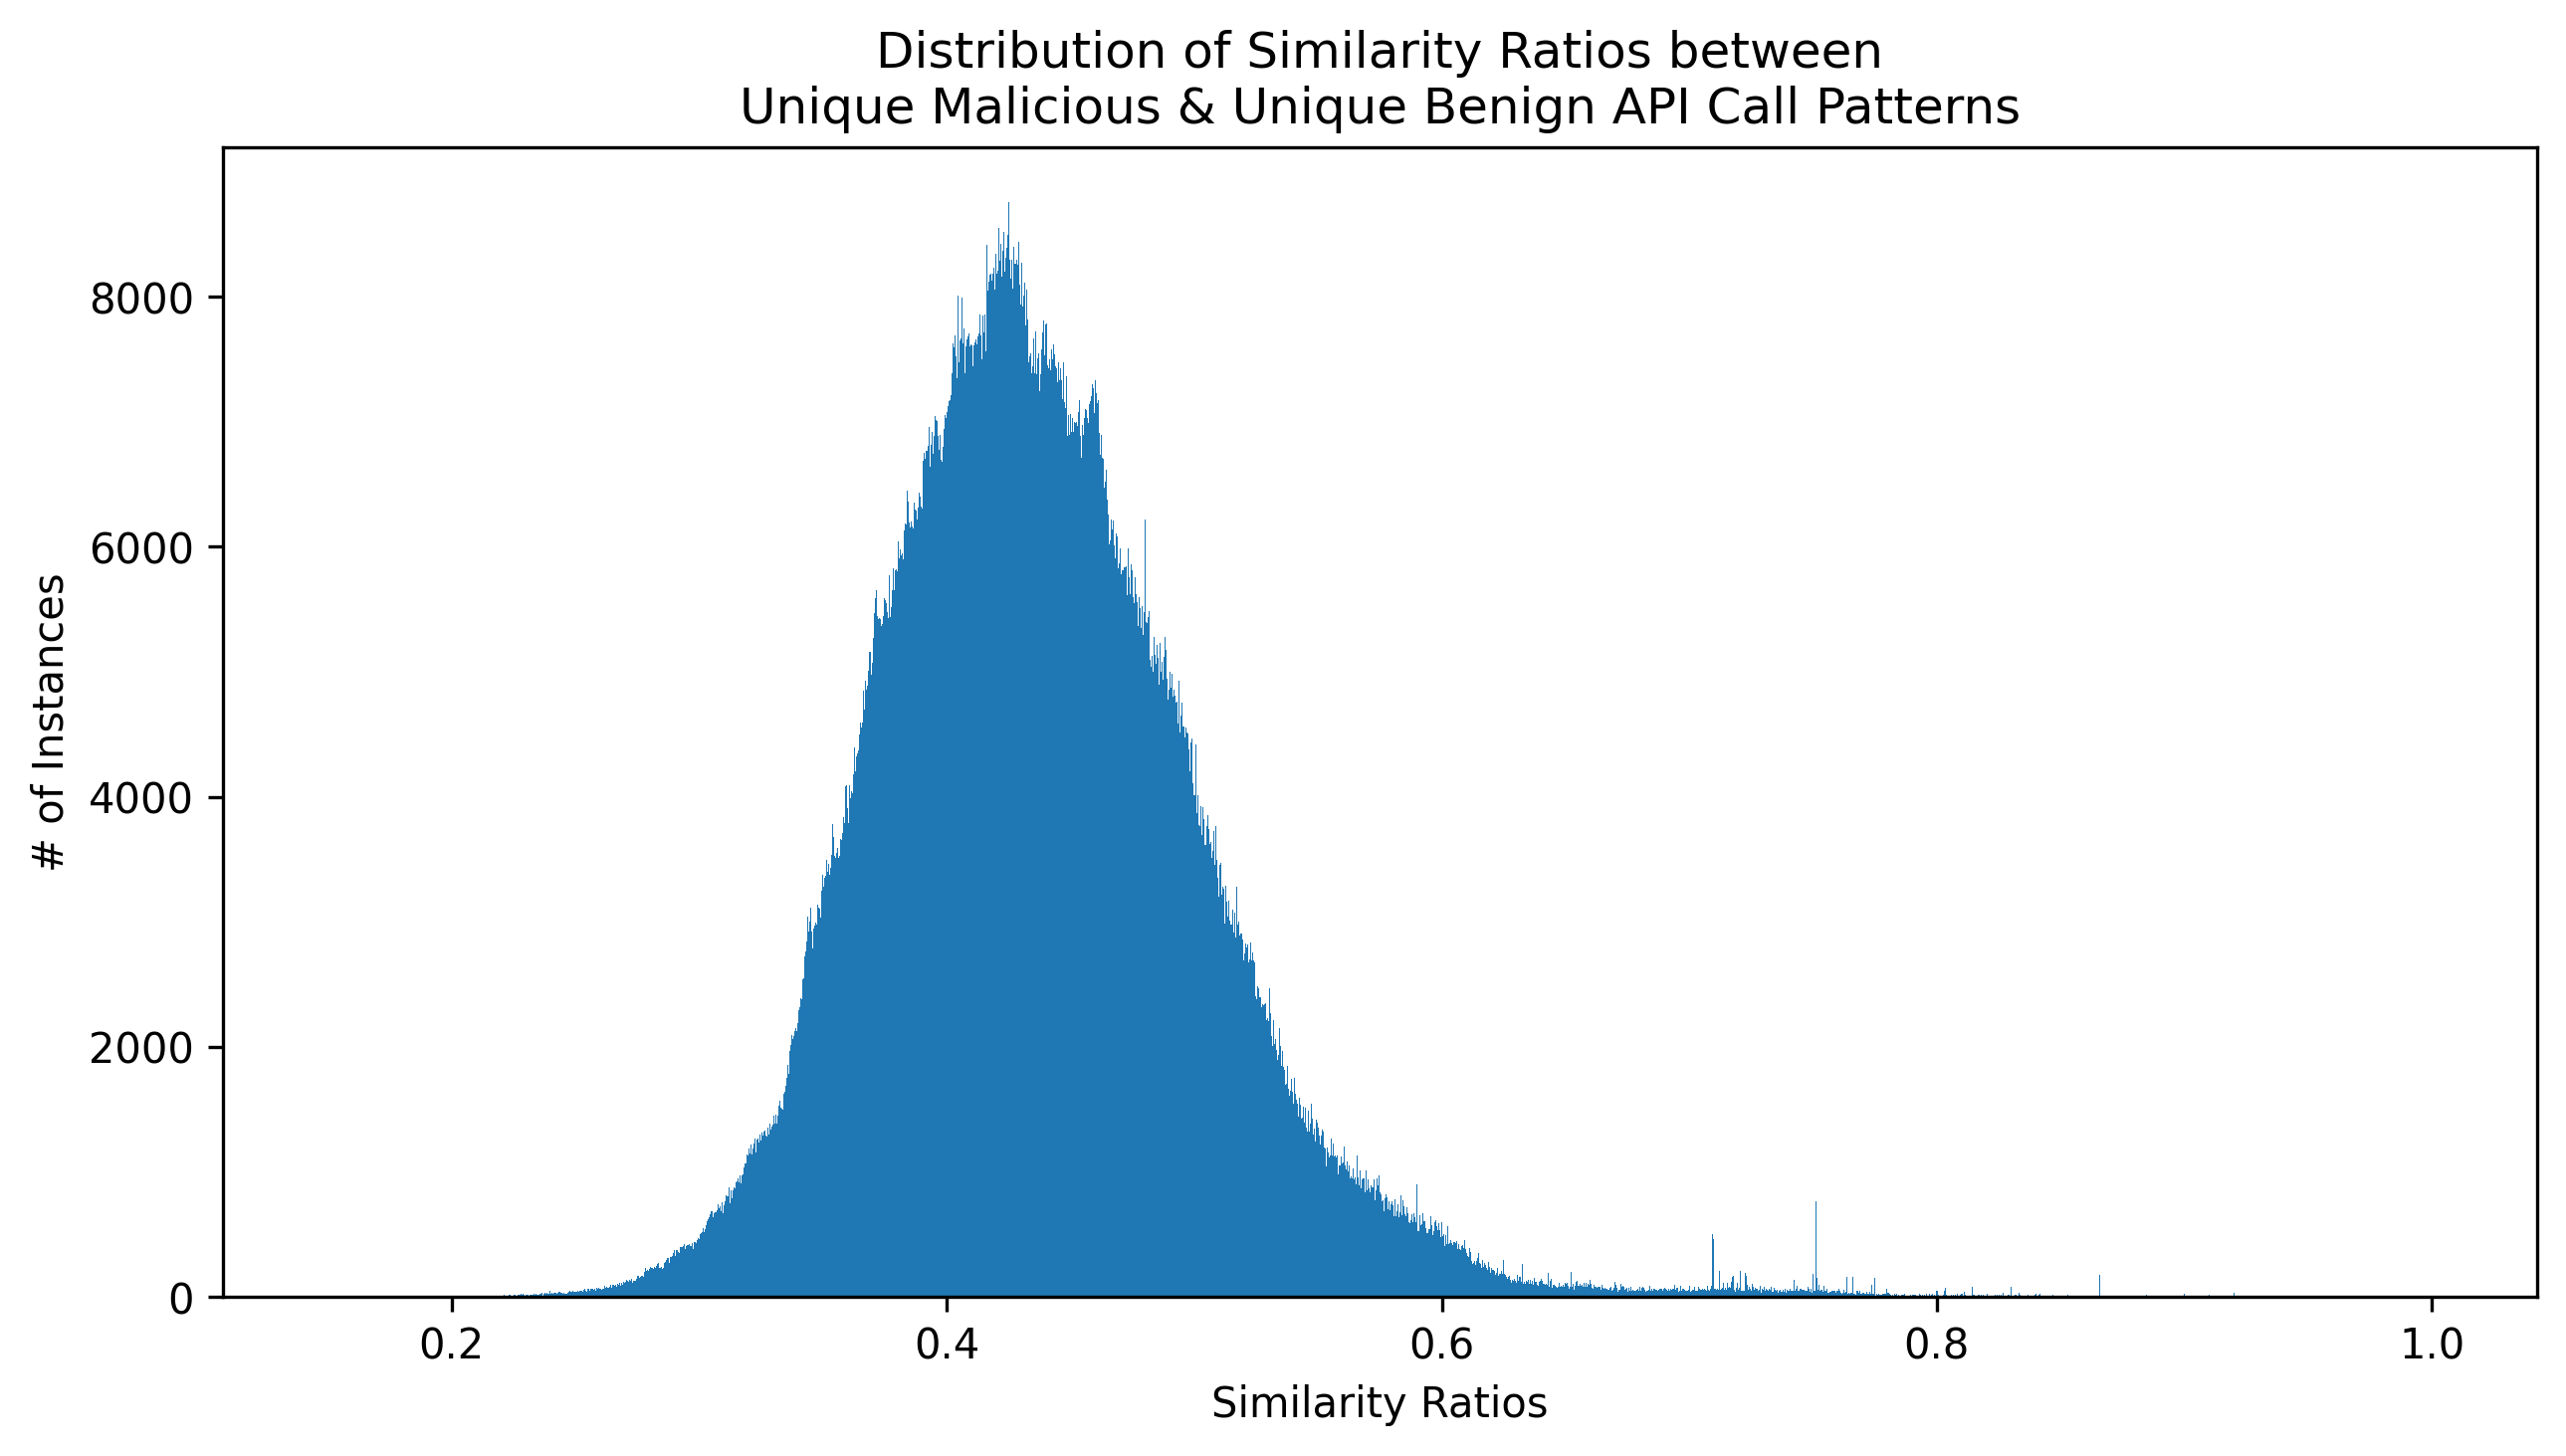

In [ ]:
ratio_only = []
for r in ratios:
    ratio_only.append(r['ratio'])
plt.figure(figsize=(10,5), dpi=300)
plt.title('Distribution of Similarity Ratios between\nUnique Malicious & Unique Benign API Call Patterns')
plt.xlabel('Similarity Ratios')
plt.ylabel('# of Instances')
n, bins, patches = plt.hist(ratio_only, bins=5000, orientation='vertical', log=False)
plt.savefig("./Output/3 Distribution_Similarity_Ratio.png")
plt.show()

In [ ]:
def print_comparison(types:str, ratios:list, max:int, rank='Most'):
    if max > len(ratios):
        print(f"The specified `max` value ({max}) exceeds the number available ratios to select.")
        max = len(ratios)
    states = []
    output = "====================================================================================\n\n"
    for r in range(0,max):
        output += f"MATCH {r+1}\n"
        output += f"Malicious Counts: {len(ratios[r]['malicious_hash'])}\n"
        # for t in range(len(ratios[r]['malicious_hash'])): # All malicious hashes that have the same API Call
        #     output += f"\t{ratios[r]['malicious_hash'][t]} - {ratios[r]['type'][t]}" + "\n"
        #output += f"Benign Counts: {len(ratios[r]['benign_hash'])}\n"
        # for b in range(len(ratios[r]['benign_hash'])): # All benign hashes that have the same API Call Pattern
        #     output += f"\t{ratios[r]['benign_hash'][b]}\n"
        counts = pd.Series(ratios[r]['type'])
        output += "\nMalware Type Counts:\n"
        output += counts.value_counts().to_string() + "\n"        
        output += f"Score: {ratios[r]['ratio']:.4f}\n" # Similarity Ratio
        output += f"\nMalicious API Call Pattern: {ratios[r]['malicious_pattern']}\n" # API Call Pattern (from Malicious)
        output += f"Benign API Call Pattern: {ratios[r]['benign_pattern']}\n" # API Call Pattern (from Benign)
        output += "\n"
        for t in range(len(ratios[r]['malicious_hash'])): # Malware Types of matching Malicious Samples
            states.append(ratios[r]['type'][t]) 
        output += f"\nBenign Samples ({len(ratios[r]['benign_hash'])}):\n"
        for t in range(len(ratios[r]['benign_hash'])): # Malware Types of matching Malicious Samples
            output += f"{ratios[r]['benign_hash'][t]}\n" 
        output += "====================================================================================\n\n"
    common_states = pd.Series(states).sort_values()
    output += "\n"
    output += f"Malware Types of the Top {max} {rank} Matching API Call Patterns to Benign Samples:\n"
    output += str(pd.Series(common_states).sort_values().value_counts()) + "\n"
    print(output, file=open(f"./Output/3 {types}.txt",'w'))
    print(output)

## High Matching Ratios

Samples with high matching ratio in terms of pattern (i.e., states) are ideally the following:
1. The malicious sample is a `trojan` hence must have similar behaviors as a benign software. It might be the limitation of the dataset having only the first 100 API calls and may not have included the rest.
2. The malicious sample is falsely labelled (i.e., `_ _ _`)as malicious (i.e., false-positive) which is supported by it matching the behavior of benign samples.

In [ ]:
# MOST SIMILAR API CALL PATTERNS TO BOTH MALICIOUS AND BENIGN SAMPLES
top = 20 # Modify to Top n Most Similar/Different
ratios.sort(reverse=True,key=lambda ratio: ratio['ratio'])
print_comparison("HighMatching_Similar", ratios, top) 


MATCH 1
Malicious Counts: 485

Malware Type Counts:
trojan        480
downloader      2
pua             2
adware          1
Score: 1.0000

Malicious API Call Pattern: GetSystemTimeAsFileTime,GetSystemInfo,NtCreateMutant,GetSystemTimeAsFileTime,NtOpenKey,NtOpenKeyEx,LdrLoadDll,LdrGetProcedureAddress,RegOpenKeyExW,LdrGetProcedureAddress,RegQueryInfoKeyW,LdrGetProcedureAddress,RegEnumKeyExW,RegOpenKeyExW,RegQueryInfoKeyW,LdrGetProcedureAddress,RegEnumValueW,LdrGetProcedureAddress,RegCloseKey,GetFileAttributesW,RegOpenKeyExW,LdrGetProcedureAddress,RegQueryValueExW,LdrGetProcedureAddress,RegQueryValueExW,RegCloseKey,FindFirstFileExW,RegOpenKeyExW,RegQueryInfoKeyW,RegEnumValueW,RegCloseKey,RegOpenKeyExW,RegQueryValueExW,RegCloseKey,FindFirstFileExW,RegOpenKeyExW,RegQueryInfoKeyW,RegCloseKey,RegOpenKeyExW,RegQueryInfoKeyW,RegCloseKey,FindFirstFileExW,RegOpenKeyExW,RegQueryValueExW,RegCloseKey,RegOpenKeyExW,RegQueryValueExW,RegCloseKey,LdrGetDllHandle,LdrGetProcedureAddress,RegOpenKeyExW,RegQ

## Low Matching Ratios

Samples with low matching ratio in terms of pattern (i.e., states) are ideally the following:
1. The malicious sample is a `trojan` hence must have similar behaviors as a benign software. It might be the limitation of the dataset having only the first 100 API calls and may not have included the rest.
2. The malicious sample is falsely labelled as malicious (i.e., false-positive) which is supported by it matching the behavior of benign samples.

In [ ]:
# MOST DIFFERENT API CALL PATTERNS TO BOTH MALICIOUS AND BENIGN SAMPLES
ratios.sort(reverse=False,key=lambda ratio: ratio['ratio'])
print_comparison("LowMatching_Different",ratios, top, 'Least')


MATCH 1
Malicious Counts: 1

Malware Type Counts:
trojan    1
Score: 0.1501

Malicious API Call Pattern: NtClose,NtOpenKey,NtQueryValueKey,NtClose,NtOpenKey,NtQueryValueKey,NtClose,LdrLoadDll,LdrGetProcedureAddress,GetSystemWindowsDirectoryW,NtCreateFile,NtCreateSection,NtMapViewOfSection,NtClose,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProc